In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
def preprocess_data(file_path):
    # Load dataset
    data = pd.read_csv(file_path)

    # Convert 'trade_date' to datetime format
   # if 'trade_date' in data.columns:
    #    data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
     #   data.set_index('trade_date', inplace=True)
    #else:
     #   raise KeyError("The dataset must contain a 'trade_date' column.")

    # Feature engineering
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['Volatility'] = data['Close'].pct_change().rolling(window=10).std()
    data.dropna(inplace=True)  # Drop rows with missing values

    # Normalize data
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = (data[numeric_cols] - data[numeric_cols].min()) / (data[numeric_cols].max() - data[numeric_cols].min())

    return data

# Load and preprocess data
file_path = '/content/bankofchina.csv'
data = preprocess_data(file_path)

In [ ]:
# Split into features and target
X = data[['MA10', 'MA50', 'Volatility', 'Volume']].values  # Replace 'vol' with your volume column if named differently
y = data['Close'].values  # Target variable

# Reshape data for LSTM input (samples, timesteps, features)
timesteps = 10
X_lstm = np.array([X[i:i+timesteps] for i in range(len(X) - timesteps)])
y_lstm = y[timesteps:]

# Split data into training and validation sets for both LSTM and XGBoost
X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)
X_train_xgb, X_val_xgb = train_test_split(X[timesteps:], test_size=0.3, random_state=42)

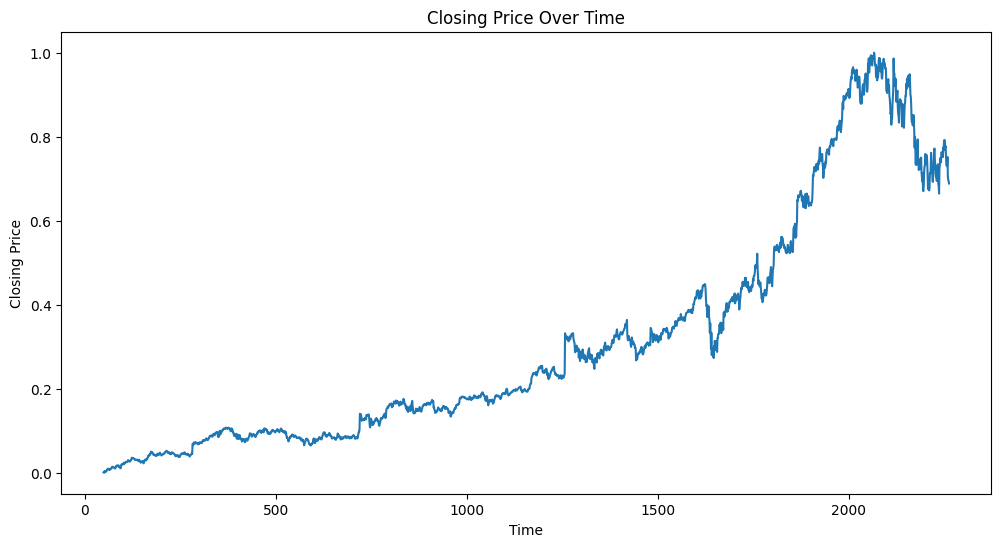

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
# Build the LSTM model
lstm_model = Sequential()

# Add LSTM layers with dropout
lstm_model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(timesteps, X_lstm.shape[2])))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(50, return_sequences=True)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))  # Only the final layer has return_sequences=False
lstm_model.add(Dropout(0.3))

# Add output layer
lstm_model.add(Dense(1, activation='relu'))

# Compile the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the LSTM model
lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Get LSTM predictions
lstm_predictions = lstm_model.predict(X_val_lstm).flatten()

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - loss: 0.0403 - mae: 0.1257 - val_loss: 0.0012 - val_mae: 0.0239 - learning_rate: 0.0010
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0030 - mae: 0.0344 - val_loss: 0.0015 - val_mae: 0.0258 - learning_rate: 0.0010
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - loss: 0.0029 - mae: 0.0344 - val_loss: 0.0018 - val_mae: 0.0275 - learning_rate: 0.0010
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - loss: 0.0023 - mae: 0.0307 - val_loss: 0.0013 - val_mae: 0.0260 - learning_rate: 0.0010
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0023 - val_mae: 0.0332 - learning_rate: 0.0010
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0029 - mae: 0.0343 - val_loss: 0.0014 - val_mae: 0.0274 - learning_rate: 0.0010
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0025 - mae: 0.0316 - val_loss: 6.0188e-04 - val_mae: 0.0156 - learning_rate: 1.0

In [ ]:
# Train the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train)
xgb_predictions = xgb_model.predict(X_val_xgb)

In [ ]:
# Ensemble predictions (weighted average)
ensemble_predictions = 0.6 * lstm_predictions + 0.4 * xgb_predictions

# Evaluate the ensemble model
mse = mean_squared_error(y_val, ensemble_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, ensemble_predictions)
r2 = r2_score(y_val, ensemble_predictions)

# Print evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")


MSE: 0.00030478124402665685
RMSE: 0.017457985107871322
Mean Absolute Error (MAE): 0.011122910415836327
R-squared (R²): 0.9960041902196292


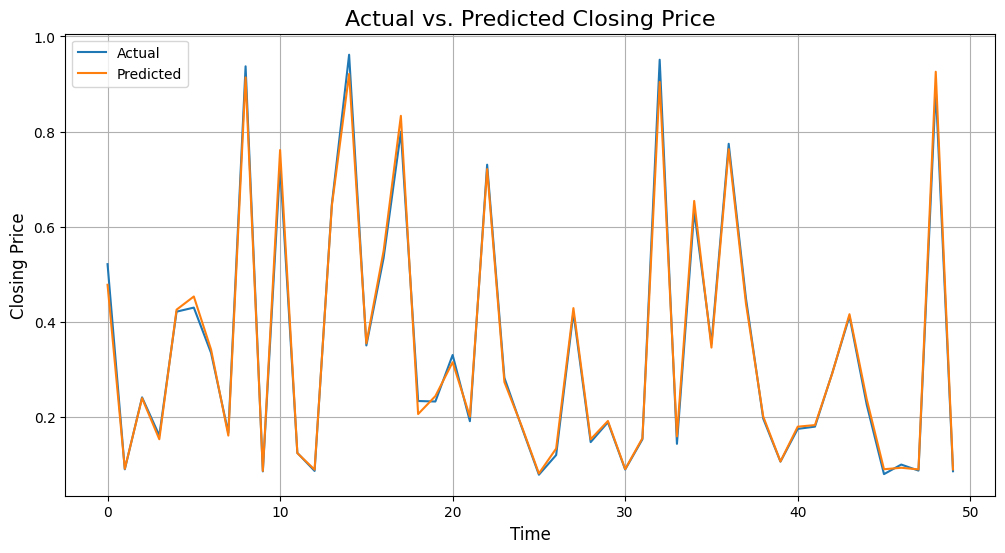

In [ ]:
start_index = len(y_val) - 50
end_index = len(y_val)

plt.figure(figsize=(12, 6))
plt.plot(y_val[start_index:end_index], label='Actual')
plt.plot(ensemble_predictions[start_index:end_index], label='Predicted')
plt.title('Actual vs. Predicted Closing Price', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()